In [1]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)

Using TensorFlow backend.


In [15]:
from time import time
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
# import metrics

In [27]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape(x.shape + (1,))
x = np.divide(x, 255.)

In [5]:
n_clusters = len(np.unique(y))
x.shape

(70000, 28, 28, 1)

In [6]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = keras.layers.InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
#         print(input_dim)
        self.input_spec = keras.layers.InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [7]:
def autoencoderConv2D_1(input_shape=(28, 28, 1), filters=[32, 64, 128, 10]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [8]:
autoencoder, encoder = autoencoderConv2D_1()

In [9]:
pretrain_epochs = 100
batch_size = 256

In [10]:
autoencoder.compile(optimizer='adadelta', loss='mse')

In [11]:
autoencoder.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
embedding (Dense)            (None, 10)                11530     
_________________________________________________________________
dense (Dense)                (None, 1152)              12672    

In [12]:
# with tf.device('/GPU:0'):
#     hist = autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
#     autoencoder.save_weights(save_dir+'temp/conv_ae_weights.h5')

In [13]:
autoencoder.save_weights('temp/conv_ae_weights.h5')

In [16]:
autoencoder, encoder = autoencoderConv2D_1()
autoencoder.load_weights('temp/conv_ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
                           outputs=[clustering_layer, autoencoder.output])

In [17]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [18]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

In [22]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [23]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.001 # tolerance threshold to stop training

In [28]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc_ = np.round(acc(y, y_pred), 5)
            nmi_ = np.round(nmi(y, y_pred), 5)
            ari_ = np.round(ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc_, nmi_, ari_), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights('temp/conv_b_DEC_model_final.h5')

c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 0: acc = 0.39719, nmi = 0.35343, ari = 0.22585  ; loss= [0.0344 0.     0.0344]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 140: acc = 0.38030, nmi = 0.38024, ari = 0.24500  ; loss= [0.02266 0.      0.02266]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 280: acc = 0.37213, nmi = 0.37317, ari = 0.22811  ; loss= [0.0204 0.     0.0204]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 420: acc = 0.37776, nmi = 0.37477, ari = 0.22684  ; loss= [0.01801 0.      0.01801]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 560: acc = 0.37707, nmi = 0.37439, ari = 0.22475  ; loss= [0.01674 0.      0.01674]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 700: acc = 0.39171, nmi = 0.37614, ari = 0.23202  ; loss= [0.01474 0.      0.01474]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 840: acc = 0.41247, nmi = 0.40088, ari = 0.25363  ; loss= [1.524e-02 3.000e-05 1.524e-02]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 980: acc = 0.43829, nmi = 0.41716, ari = 0.27473  ; loss= [0.01498 0.00011 0.01497]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 1120: acc = 0.45454, nmi = 0.43977, ari = 0.29324  ; loss= [0.01406 0.00037 0.01402]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 1260: acc = 0.47446, nmi = 0.45633, ari = 0.30860  ; loss= [0.01392 0.00054 0.01387]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 1400: acc = 0.48813, nmi = 0.46911, ari = 0.32256  ; loss= [0.01376 0.00251 0.01351]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 1540: acc = 0.49331, nmi = 0.48671, ari = 0.33585  ; loss= [0.01682 0.02653 0.01417]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 1680: acc = 0.50740, nmi = 0.50778, ari = 0.35499  ; loss= [0.02504 0.08093 0.01695]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 1820: acc = 0.52660, nmi = 0.52914, ari = 0.37562  ; loss= [0.03148 0.1456  0.01692]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 1960: acc = 0.53907, nmi = 0.54596, ari = 0.38864  ; loss= [0.03472 0.16576 0.01814]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 2100: acc = 0.55363, nmi = 0.56043, ari = 0.40234  ; loss= [0.03513 0.18017 0.01712]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 2240: acc = 0.56403, nmi = 0.57011, ari = 0.41303  ; loss= [0.03689 0.18625 0.01826]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 2380: acc = 0.57509, nmi = 0.58233, ari = 0.42520  ; loss= [0.03709 0.19374 0.01771]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 2520: acc = 0.58476, nmi = 0.59210, ari = 0.43556  ; loss= [0.03926 0.18847 0.02041]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 2660: acc = 0.59127, nmi = 0.60091, ari = 0.44405  ; loss= [0.0367  0.18708 0.01799]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 2800: acc = 0.59507, nmi = 0.60639, ari = 0.44909  ; loss= [0.03429 0.17168 0.01712]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 2940: acc = 0.59671, nmi = 0.61053, ari = 0.45207  ; loss= [0.0368  0.17825 0.01898]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 3080: acc = 0.59897, nmi = 0.61325, ari = 0.45467  ; loss= [0.03319 0.17174 0.01602]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 3220: acc = 0.60279, nmi = 0.61865, ari = 0.45971  ; loss= [0.0335  0.17184 0.01632]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 3360: acc = 0.60726, nmi = 0.62257, ari = 0.46459  ; loss= [0.03392 0.16694 0.01722]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 3500: acc = 0.60976, nmi = 0.62639, ari = 0.46772  ; loss= [0.03437 0.16495 0.01787]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 3640: acc = 0.61369, nmi = 0.62924, ari = 0.47214  ; loss= [0.03314 0.15567 0.01757]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 3780: acc = 0.61286, nmi = 0.63098, ari = 0.47321  ; loss= [0.03163 0.14713 0.01692]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 3920: acc = 0.61349, nmi = 0.63323, ari = 0.47532  ; loss= [0.03085 0.14193 0.01666]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 4060: acc = 0.61669, nmi = 0.63569, ari = 0.47878  ; loss= [0.03154 0.14625 0.01691]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 4200: acc = 0.61900, nmi = 0.63759, ari = 0.48158  ; loss= [0.03007 0.13406 0.01667]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 4340: acc = 0.61941, nmi = 0.63823, ari = 0.48216  ; loss= [0.03087 0.14003 0.01687]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 4480: acc = 0.61947, nmi = 0.63947, ari = 0.48344  ; loss= [0.03065 0.14962 0.01569]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 4620: acc = 0.61750, nmi = 0.63794, ari = 0.48089  ; loss= [0.0302  0.13297 0.0169 ]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 4760: acc = 0.61724, nmi = 0.63990, ari = 0.48216  ; loss= [0.03001 0.13914 0.0161 ]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 4900: acc = 0.61863, nmi = 0.64072, ari = 0.48322  ; loss= [0.02993 0.13171 0.01676]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 5040: acc = 0.61936, nmi = 0.64138, ari = 0.48433  ; loss= [0.02879 0.13273 0.01552]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 5180: acc = 0.61931, nmi = 0.64094, ari = 0.48369  ; loss= [0.03065 0.12564 0.01809]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 5320: acc = 0.62027, nmi = 0.64225, ari = 0.48554  ; loss= [0.02816 0.12567 0.0156 ]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 5460: acc = 0.61977, nmi = 0.64264, ari = 0.48490  ; loss= [0.02916 0.13375 0.01579]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 5600: acc = 0.61891, nmi = 0.64221, ari = 0.48444  ; loss= [0.02761 0.11193 0.01641]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 5740: acc = 0.61926, nmi = 0.64373, ari = 0.48528  ; loss= [0.02874 0.12504 0.01624]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 5880: acc = 0.61779, nmi = 0.64312, ari = 0.48459  ; loss= [0.02877 0.12313 0.01646]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 6020: acc = 0.61854, nmi = 0.64491, ari = 0.48597  ; loss= [0.0272  0.11605 0.0156 ]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 6160: acc = 0.61920, nmi = 0.64517, ari = 0.48699  ; loss= [0.0276  0.10713 0.01688]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 6300: acc = 0.61861, nmi = 0.64507, ari = 0.48669  ; loss= [0.02616 0.10233 0.01593]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 6440: acc = 0.61937, nmi = 0.64596, ari = 0.48792  ; loss= [0.02596 0.10728 0.01523]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 6580: acc = 0.61944, nmi = 0.64619, ari = 0.48772  ; loss= [0.0269  0.10736 0.01617]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 6720: acc = 0.61956, nmi = 0.64680, ari = 0.48871  ; loss= [0.02516 0.10269 0.01489]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 6860: acc = 0.62024, nmi = 0.64754, ari = 0.48934  ; loss= [0.02796 0.10565 0.0174 ]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 7000: acc = 0.62116, nmi = 0.64783, ari = 0.48983  ; loss= [0.02547 0.09604 0.01587]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 7140: acc = 0.62123, nmi = 0.64781, ari = 0.49000  ; loss= [0.02679 0.10603 0.01619]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 7280: acc = 0.62143, nmi = 0.64806, ari = 0.48970  ; loss= [0.02496 0.09921 0.01504]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 7420: acc = 0.62091, nmi = 0.64762, ari = 0.48904  ; loss= [0.02838 0.11184 0.0172 ]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 7560: acc = 0.62061, nmi = 0.64783, ari = 0.48921  ; loss= [0.02472 0.09588 0.01514]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 7700: acc = 0.62103, nmi = 0.64860, ari = 0.48994  ; loss= [0.02612 0.10041 0.01608]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 7840: acc = 0.62069, nmi = 0.64870, ari = 0.49017  ; loss= [0.02816 0.10868 0.01729]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 7980: acc = 0.61956, nmi = 0.64841, ari = 0.48953  ; loss= [0.02348 0.08951 0.01453]


NameError: name 'save_dir' is not defined

In [29]:
model.save_weights('temp/conv_b_DEC_model_final.h5')

In [31]:
model.load_weights('temp/conv_b_DEC_model_final.h5')

In [32]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc_ = np.round(acc(y, y_pred), 5)
    nmi_ = np.round(nmi(y, y_pred), 5)
    ari_ = np.round(ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc_, nmi_, ari_), ' ; loss=', loss)

Acc = 0.62084, nmi = 0.64870, ari = 0.49057  ; loss= [0.02804 0.10605 0.01743]


c:\00_data\python38\lib\site-packages\sklearn\utils\linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


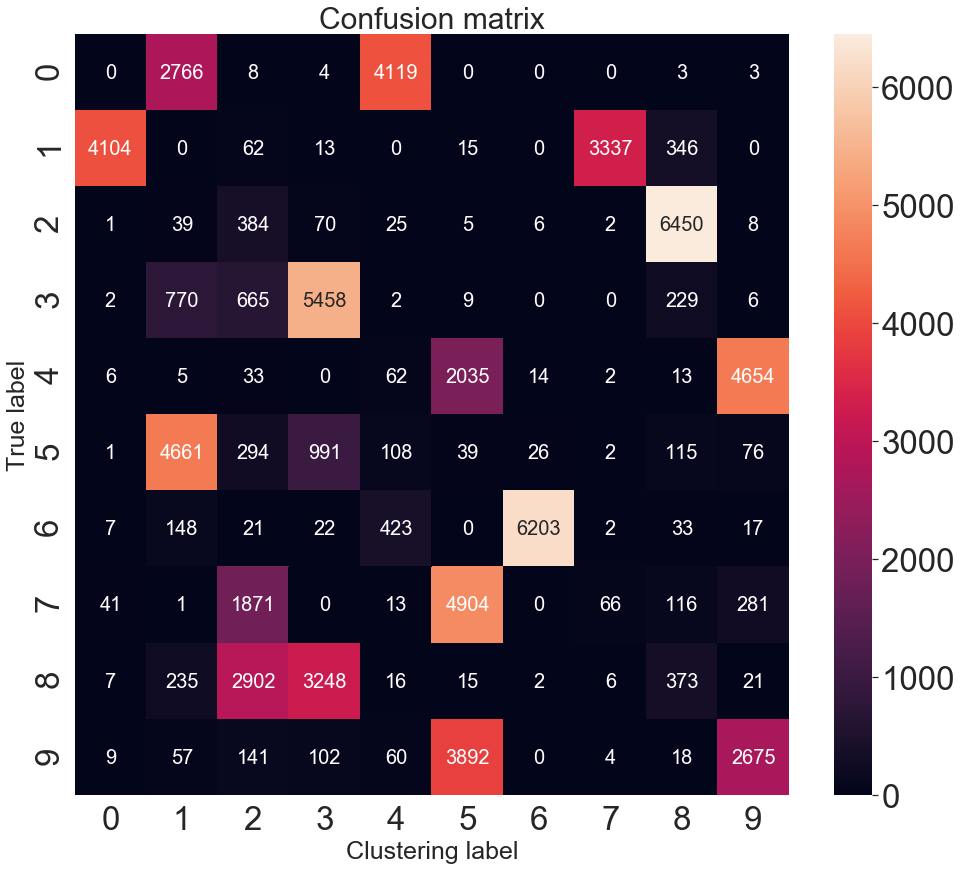

In [34]:
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()
